In [ ]:
# pip install torchvision

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit 
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap, TwoLocal

In [64]:
class QNN(nn.Module):
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit.
    This is where the embedding happens
    """
    
    def get_two_locals(self,feature_dim, rotations, var_form_rep, ent):
        return TwoLocal(num_qubits=feature_dim, rotation_blocks=rotations, entanglement_blocks='cx', entanglement=ent, reps=var_form_rep)
    
    def parity(self, x, num_classes):
        return f"{x:b}".count("1") % num_classes
    
    def one_qubit_binary(self,x):
        return x % 2
    
    def __init__(self, backend, shots, nb_features=4, entanglement_type='linear',reps1=1,reps2=2):
        super(QNN, self).__init__()
        # --- Circuit definition ---

        
        #self._circuit=QuantumCircuit(nb_features)
        self._fmap_zz = ZZFeatureMap(feature_dimension=nb_features, reps=reps1, entanglement= entanglement_type)
        #self._circuit = PauliFeatureMap(feature_dimension=nb_features, reps=1, entanglement= entanglement_type)
        #self._circuit = ZFeatureMap(feature_dimension=nb_features, reps=1)
        self._ansatz_tl = self.get_two_locals(nb_features, ['ry', 'rz'], reps2, entanglement_type)
        #print(ansatz_tl.draw("mpl"))
        
        self._circuit=self._fmap_zz.compose(self._ansatz_tl)
        self.n_features = len(self._fmap_zz.parameters)
        self.num_weights_two_local=len(self._ansatz_tl.parameters) 

#         self._weights = np.random.random(len(self._ansatz_tl.parameters))
#         self._circuit.add_register(ClassicalRegister(1))
#         self._circuit.measure(nb_features-1,0)
        self.num_parameters = len(self._circuit.parameters)
        # ---------------------------

        self.num_classes = 2
        self.backend = backend
        self.shots = shots
#         print(shots)
        self.qinst=QuantumInstance(backend, shots)
        self.qnn = CircuitQNN(circuit=self._circuit,
                     input_params=self._fmap_zz.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                     weight_params=self._ansatz_tl.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                     interpret=self.one_qubit_binary,
                     output_shape=self.num_classes,
                     gradient=None,
                     quantum_instance=self.qinst,
                    input_gradients=True)
        
        
    
    def forward(self, thetas):
#         if torch.is_tensor(thetas):
#             thetas=thetas.detach().numpy()
        return self.qnn.forward(thetas[:self.n_features], thetas[self.n_features:])
    
    def backward(self, thetas):
#         if torch.is_tensor(thetas):
#             thetas=thetas.detach().numpy()
        return self.qnn.backward(thetas[:self.n_features], thetas[self.n_features:])
        

Expected value for rotation pi [[0.54 0.46]]


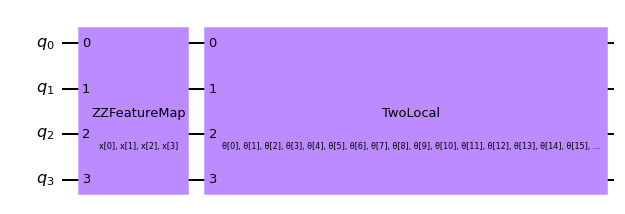

In [65]:
simulator = qiskit.Aer.get_backend('aer_simulator')

circuit = QNN(simulator, 100)
print('Expected value for rotation pi {}'.format(circuit(torch.randn(circuit.num_parameters))))
circuit._circuit.draw("mpl")

In [34]:
# Concentrating on the first 100 samples
n_samples = 100

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

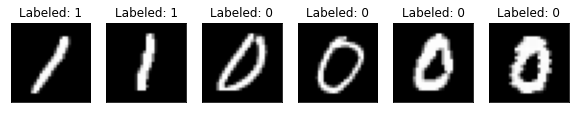

In [35]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

In [36]:
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [54]:
class Net(nn.Module):
    def __init__(self, qnn):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, len(qnn.input_params))
        self.qnn = TorchConnector(qnn)
        self.fc3 = nn.Linear(2, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)
        x = self.fc3(x)
        return torch.cat((x, 1 - x), -1)

In [66]:
simulator = qiskit.Aer.get_backend('aer_simulator')
circuit = QNN(simulator, 100)

model = Net(circuit.qnn)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

Training [5%]	Loss: -0.5918
Training [10%]	Loss: -0.7207
Training [15%]	Loss: -0.8570
Training [20%]	Loss: -0.9730
Training [25%]	Loss: -1.1183
Training [30%]	Loss: -1.2756
Training [35%]	Loss: -1.4099
Training [40%]	Loss: -1.5363
Training [45%]	Loss: -1.6868
Training [50%]	Loss: -1.8072
Training [55%]	Loss: -1.9688
Training [60%]	Loss: -2.1056
Training [65%]	Loss: -2.2631
Training [70%]	Loss: -2.3794
Training [75%]	Loss: -2.5359
Training [80%]	Loss: -2.6791
Training [85%]	Loss: -2.8283
Training [90%]	Loss: -2.9526
Training [95%]	Loss: -3.0993
Training [100%]	Loss: -3.2538


Text(0, 0.5, 'Neg Log Likelihood Loss')

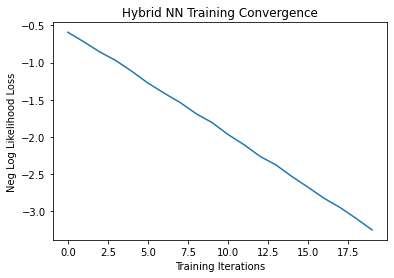

In [67]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [68]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -3.2795
	Accuracy: 100.0%


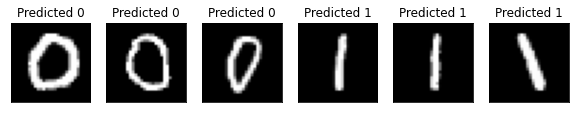

In [69]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1